# Discover Symmetry of Kepler in 2D (Training)

## Import packages

In [1]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torch.distributions.uniform import Uniform
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from glob import glob
from netCDF4 import Dataset

from scipy.integrate import odeint
# from functools import partial
# import multiprocessing

In [2]:
torch.manual_seed(8407)

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

## Play with Data

* Data: $(x,y,v_x,v_y)$


* Hamiltonian:
    $$H = \frac{p^2}{2m} - \frac{GMm}{r}$$
    

* Hamilton's Equation of motion (assume $m=1$):

    \begin{align}
    \dot{x} &= \partial_{p_x}H = p_x = v_x \\
    \dot{v_x} &= -\partial_x H = -\frac{GM}{r^3}x \\
    \dot{y} &= \partial_{p_y}H = p_y = v_y \\
    \dot{v_y} &= -\partial_y H = -\frac{GM}{r^3}y
    \end{align}

In [4]:
G = 1
M = 1

In [5]:
def eom(z, t):
    x, y, vx, vy = z
    dxdt = vx
    dydt = vy
    dvxdt = - G * M / (x**2 + y**2)**(3/2) * x
    dvydt = - G * M / (x**2 + y**2)**(3/2) * y
    return [dxdt, dydt, dvxdt, dvydt]

In [6]:
z0 = [1, 1, -0.3, 0.3]
print(z0)
t = torch.linspace(0, 5, 1000)

[1, 1, -0.3, 0.3]


In [7]:
z = odeint(eom, z0, t)

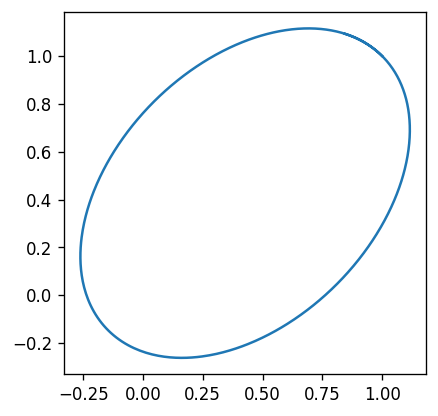

In [8]:
plt.figure(dpi=120)
plt.plot(z[:,0], z[:,1])
ax = plt.gca()
ax.set_aspect("equal")

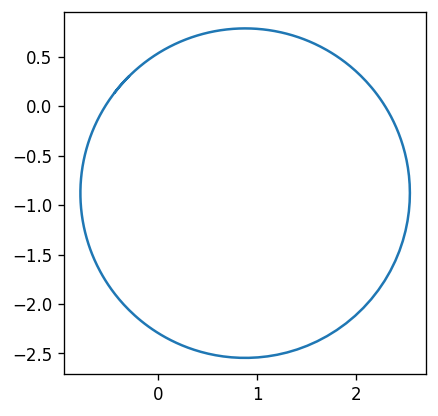

In [9]:
plt.figure(dpi=120)
plt.plot(z[:,2], z[:,3])
ax = plt.gca()
ax.set_aspect("equal")

In [10]:
# # pool = multiprocessing.pool.ThreadPool(12)
        
# t = torch.linspace(0., 10., 100)
# u_r = Uniform(1, 2)
# u_th = Uniform(0, 2*np.pi)
# u_e = Uniform(-0.1,0.1)
# u_vx = Uniform(-0.2,-0.1)
# u_vy = Uniform(0.1,0.2)
# n = 100
# r = u_r.sample((n,))
# th= u_th.sample((n,))
# x = r*torch.cos(th)
# y = r*torch.sin(th)
# vx = -0.5*y + u_e.sample((n,))
# vy = 0.5*x + u_e.sample((n,))
# z = torch.column_stack([
#     x, 
#     y, 
#     u_vx.sample((n,)),
#     u_vy.sample((n,))
# ])

# def ode_fn(i):
#     return torch.Tensor(odeint(eom, z[i,:], t)).float()

# sol = pool.map(ode_fn, range(0, n))

In [11]:
# for i in range(n):
#     plt.plot(sol[i][:,0], sol[i][:,1])
# plt.show()

In [12]:
# sol_stack = torch.stack(sol, dim=2).permute(0,2,1)

In [13]:
# pts = torch.vstack([torch.randperm(100)[:2] for i in range(n)])
# X = torch.Tensor(100,4)
# X_p = torch.Tensor(100,4)
# for i in range(100):
#     X[i,:] = sol_stack[i,pts[i,0],:]
#     X_p[i,:] = sol_stack[i,pts[i,1],:]
# print(X.shape)
# print(X_p.shape)

In [14]:
data = glob("data/*.nc")

In [15]:
len(data)

60000

In [16]:
data[0]

'data/kepler2d_19786.nc'

In [17]:
data_list = []
for file in data:
    data_set = Dataset(file)
    var = data_set.variables
    x = torch.Tensor(var["x"][:]).float()
    y = torch.Tensor(var["y"][:]).float()
    vx = torch.Tensor(var["vx"][:]).float()
    vy = torch.Tensor(var["vy"][:]).float()
    if torch.count_nonzero((torch.abs(x) > 3) | (torch.abs(y) > 3)).item() == 0:
        df = torch.column_stack([x, y, vx, vy])
        data_list.append(df)
print(len(data_list))

58864


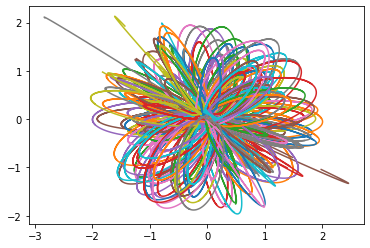

In [93]:
for i in range(200):
    plt.plot(data_list[i][:,0], data_list[i][:,1])
plt.show()

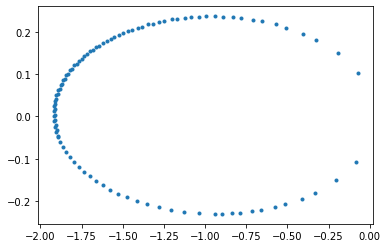

tensor([-1.8904, -0.0452, -0.1144,  0.1224])


In [19]:
plt.plot(data_list[25][:,0], data_list[25][:,1], '.')
plt.show()
print(data_list[25][0,:])

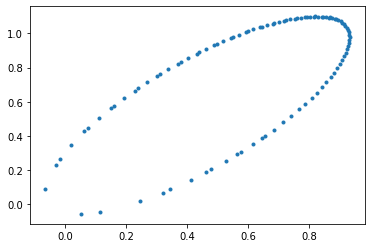

In [20]:
plt.plot(data_list[34][:,0], data_list[34][:,1], '.')
plt.show()

In [21]:
a = data_list[32][0]
a[0]/a[1] - a[2]/a[3]

tensor(1.8319)

In [22]:
idx = torch.randperm(len(data_list))[:10]
idx

tensor([54799, 47447,  7900, 21888, 52783, 39175, 42404, 47872,  1088, 31342])

In [23]:
data_t = torch.stack(data_list, dim=2).permute(2,0,1)
data_t.shape

torch.Size([58864, 101, 4])

In [24]:
training_list = data_list[:50000]
val_list = data_list[50000:55000]

## Implement Dataset

In [25]:
class Kepler2D(torch.utils.data.Dataset):
    def __init__(self, data_list, n):
        assert n <= len(data_list)
        idx = torch.randperm(len(data_list))[:n]
        data_t = torch.stack(data_list, dim=2).permute(2, 0, 1)
        data_t = data_t[idx]
        row = data_t.shape[1]
        
        # Positive Pair
        pts = torch.vstack([torch.randperm(row)[:3] for i in range(n)]) # 각 궤도에서 랜덤으로 점 3개 선택
        X = torch.Tensor(n, 4)
        X_p = torch.Tensor(n, 4)
        X_n = torch.Tensor(n, 4)
        X_n[0,:] = data_t[n-1,pts[0,2],:]
        for i in range(n):
            X[i,:] = data_t[i,pts[i,0],:]
            X_p[i,:] = data_t[i,pts[i,1],:]
            if i > 0:
                X_n[i,:] = data_t[i-1,pts[i,2],:]  # Positive pair들의 다음 궤도 선택 (항상 다른 궤도 보장)
        
        # Mix Pairs with label
        self.X = X
        self.X_p = X_p
        self.X_n = X_n
        
    def __len__(self):
        return self.X.shape[0]
    
    def __getitem__(self, idx):
        x = torch.Tensor(self.X[idx])
        x_p = torch.Tensor(self.X_p[idx])
        x_n = torch.Tensor(self.X_n[idx])
        return x, x_p, x_n

In [26]:
# t_train = (0, 10, 100)
# t_valid = (0, 10, 100)

In [27]:
train_dataset = Kepler2D(training_list, 50000)
valid_dataset = Kepler2D(val_list, 5000)

train_dataloader = DataLoader(train_dataset, batch_size=500, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=500)

dataloaders_dict = {
    "train": train_dataloader,
    "val": valid_dataloader
}

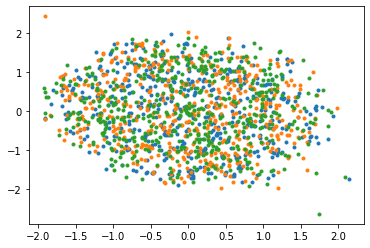

In [28]:
for _, samples in enumerate(train_dataloader):
    x, x_p, x_n = samples
    
    plt.plot(x[:,0], x[:,1], '.')
    plt.plot(x_p[:,0], x_p[:,1], '.')
    plt.plot(x_n[:,0], x_n[:,1], '.')
    plt.show()
    break

## Implement Siamese Network

In [29]:
class SNN(nn.Module):
    def __init__(self):
        super(SNN, self).__init__()
        self.linear_relu = nn.Sequential(
            nn.Linear(4,100),
            nn.ReLU(),
            nn.Linear(100,1),
            nn.ReLU()
        )

    def forward(self, x, x_p, x_n):
        out1 = self.linear_relu(x)
        out2 = self.linear_relu(x_p)
        out3 = self.linear_relu(x_n)
        return out1, out2, out3

In [30]:
net = SNN()
print(net)

SNN(
  (linear_relu): Sequential(
    (0): Linear(in_features=4, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=1, bias=True)
    (3): ReLU()
  )
)


## Implement Loss & Optimizer

In [31]:
criterion = nn.TripletMarginLoss()
optimizer = optim.Adam(net.parameters(), lr=0.01)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=10)

In [32]:
def train(net, dataloaders_dict, criterion, optimizer, num_epochs, dist=1):
    train_loss = []
    val_loss = []
    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        print("----------------------")
        
        for phase in ['train', 'val']:
            if phase == 'train':
                net.train()
            else:
                net.eval()
                
            epoch_loss = 0.0
            epoch_corr = 0
            
            data = dataloaders_dict[phase]
            for batch, samples in enumerate(tqdm(data)):
                X, X_p, X_n = samples
                X, X_p, X_n = X.to(device), X_p.to(device), X_n.to(device)
                
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase=="train"):
                    out1, out2, out3 = net(X, X_p, X_n)
                    loss = criterion(out1, out2, out3)
                    
                    if phase == "train":
                        loss.backward()
                        optimizer.step()
                    
                    epoch_loss += loss.item() + X.shape[0]
                    epoch_corr += torch.count_nonzero(torch.abs(out1 - out2) <= torch.abs(out1 - out3)).item()
                    
            epoch_loss = epoch_loss / len(data.dataset)
            epoch_acc = epoch_corr / len(data.dataset)
            
            if phase == 'train':
                train_loss.append(epoch_loss)
            else:
                val_loss.append(epoch_loss)
                scheduler.step(epoch_loss)
                lr = scheduler._last_lr[0]
                print(f" Validation Loss: {epoch_loss:>8f}")
                print(f" Validation Acc : {epoch_acc:>8f}")
                print(f" Learning Rate  : {lr:>8f}\n")
                if lr < 1e-6:
                    return train_loss, val_loss
            
    return train_loss, val_loss

In [33]:
train_loss, val_loss = train(net, dataloaders_dict, criterion, optimizer, 500, 0.6)

 10%|█         | 10/100 [00:00<00:00, 92.81it/s]

Epoch 1/500
----------------------


 10%|█         | 10/100 [00:00<00:00, 93.59it/s]

 Validation Loss: 1.000531
 Validation Acc : 0.914800
 Learning Rate  : 0.010000

Epoch 2/500
----------------------


 13%|█▎        | 13/100 [00:00<00:00, 126.58it/s]

 Validation Loss: 1.000426
 Validation Acc : 0.930800
 Learning Rate  : 0.010000

Epoch 3/500
----------------------


 13%|█▎        | 13/100 [00:00<00:00, 125.87it/s]

 Validation Loss: 1.000378
 Validation Acc : 0.941000
 Learning Rate  : 0.010000

Epoch 4/500
----------------------


 13%|█▎        | 13/100 [00:00<00:00, 124.21it/s]

 Validation Loss: 1.000359
 Validation Acc : 0.943200
 Learning Rate  : 0.010000

Epoch 5/500
----------------------


 13%|█▎        | 13/100 [00:00<00:00, 121.69it/s]

 Validation Loss: 1.000330
 Validation Acc : 0.948800
 Learning Rate  : 0.010000

Epoch 6/500
----------------------


 10%|█         | 10/100 [00:00<00:00, 92.75it/s]

 Validation Loss: 1.000333
 Validation Acc : 0.944200
 Learning Rate  : 0.010000

Epoch 7/500
----------------------


 10%|█         | 10/100 [00:00<00:00, 98.67it/s]

 Validation Loss: 1.000316
 Validation Acc : 0.947600
 Learning Rate  : 0.010000

Epoch 8/500
----------------------


 10%|█         | 10/100 [00:00<00:00, 97.06it/s]

 Validation Loss: 1.000321
 Validation Acc : 0.946200
 Learning Rate  : 0.010000

Epoch 9/500
----------------------


 13%|█▎        | 13/100 [00:00<00:00, 127.99it/s]

 Validation Loss: 1.000288
 Validation Acc : 0.958400
 Learning Rate  : 0.010000

Epoch 10/500
----------------------


 10%|█         | 10/100 [00:00<00:00, 96.98it/s]

 Validation Loss: 1.000303
 Validation Acc : 0.953800
 Learning Rate  : 0.010000

Epoch 11/500
----------------------


 13%|█▎        | 13/100 [00:00<00:00, 128.42it/s]

 Validation Loss: 1.000296
 Validation Acc : 0.958000
 Learning Rate  : 0.010000

Epoch 12/500
----------------------


 13%|█▎        | 13/100 [00:00<00:00, 126.45it/s]

 Validation Loss: 1.000270
 Validation Acc : 0.958200
 Learning Rate  : 0.010000

Epoch 13/500
----------------------


 13%|█▎        | 13/100 [00:00<00:00, 125.97it/s]

 Validation Loss: 1.000253
 Validation Acc : 0.960400
 Learning Rate  : 0.010000

Epoch 14/500
----------------------


 13%|█▎        | 13/100 [00:00<00:00, 128.48it/s]

 Validation Loss: 1.000318
 Validation Acc : 0.948600
 Learning Rate  : 0.010000

Epoch 15/500
----------------------


 10%|█         | 10/100 [00:00<00:00, 91.37it/s]

 Validation Loss: 1.000271
 Validation Acc : 0.956800
 Learning Rate  : 0.010000

Epoch 16/500
----------------------


 13%|█▎        | 13/100 [00:00<00:00, 124.78it/s]

 Validation Loss: 1.000260
 Validation Acc : 0.957800
 Learning Rate  : 0.010000

Epoch 17/500
----------------------


 13%|█▎        | 13/100 [00:00<00:00, 122.27it/s]

 Validation Loss: 1.000270
 Validation Acc : 0.957800
 Learning Rate  : 0.010000

Epoch 18/500
----------------------


 12%|█▏        | 12/100 [00:00<00:00, 115.43it/s]

 Validation Loss: 1.000266
 Validation Acc : 0.955800
 Learning Rate  : 0.001000

Epoch 19/500
----------------------


  9%|▉         | 9/100 [00:00<00:01, 79.55it/s]

 Validation Loss: 1.000243
 Validation Acc : 0.963800
 Learning Rate  : 0.001000

Epoch 20/500
----------------------


 12%|█▏        | 12/100 [00:00<00:00, 112.27it/s]

 Validation Loss: 1.000243
 Validation Acc : 0.962600
 Learning Rate  : 0.001000

Epoch 21/500
----------------------


 14%|█▍        | 14/100 [00:00<00:00, 131.26it/s]

 Validation Loss: 1.000241
 Validation Acc : 0.963800
 Learning Rate  : 0.001000

Epoch 22/500
----------------------


  6%|▌         | 6/100 [00:00<00:01, 55.01it/s]

 Validation Loss: 1.000240
 Validation Acc : 0.963600
 Learning Rate  : 0.001000

Epoch 23/500
----------------------


 13%|█▎        | 13/100 [00:00<00:00, 124.91it/s]

 Validation Loss: 1.000239
 Validation Acc : 0.965600
 Learning Rate  : 0.001000

Epoch 24/500
----------------------


 10%|█         | 10/100 [00:00<00:00, 96.59it/s]

 Validation Loss: 1.000235
 Validation Acc : 0.968400
 Learning Rate  : 0.001000

Epoch 25/500
----------------------


 13%|█▎        | 13/100 [00:00<00:00, 125.34it/s]

 Validation Loss: 1.000238
 Validation Acc : 0.964200
 Learning Rate  : 0.001000

Epoch 26/500
----------------------


 13%|█▎        | 13/100 [00:00<00:00, 124.89it/s]

 Validation Loss: 1.000240
 Validation Acc : 0.964200
 Learning Rate  : 0.001000

Epoch 27/500
----------------------


 13%|█▎        | 13/100 [00:00<00:00, 129.32it/s]

 Validation Loss: 1.000238
 Validation Acc : 0.966600
 Learning Rate  : 0.001000

Epoch 28/500
----------------------


 13%|█▎        | 13/100 [00:00<00:00, 124.69it/s]

 Validation Loss: 1.000239
 Validation Acc : 0.964400
 Learning Rate  : 0.001000

Epoch 29/500
----------------------


 12%|█▏        | 12/100 [00:00<00:00, 116.01it/s]

 Validation Loss: 1.000240
 Validation Acc : 0.964200
 Learning Rate  : 0.000100

Epoch 30/500
----------------------


 11%|█         | 11/100 [00:00<00:00, 107.11it/s]

 Validation Loss: 1.000238
 Validation Acc : 0.966000
 Learning Rate  : 0.000100

Epoch 31/500
----------------------


 13%|█▎        | 13/100 [00:00<00:00, 123.87it/s]

 Validation Loss: 1.000238
 Validation Acc : 0.965800
 Learning Rate  : 0.000100

Epoch 32/500
----------------------


 10%|█         | 10/100 [00:00<00:00, 97.98it/s]

 Validation Loss: 1.000238
 Validation Acc : 0.964600
 Learning Rate  : 0.000100

Epoch 33/500
----------------------


 13%|█▎        | 13/100 [00:00<00:00, 129.42it/s]

 Validation Loss: 1.000239
 Validation Acc : 0.965400
 Learning Rate  : 0.000100

Epoch 34/500
----------------------


 14%|█▍        | 14/100 [00:00<00:00, 131.82it/s]

 Validation Loss: 1.000238
 Validation Acc : 0.966200
 Learning Rate  : 0.000100

Epoch 35/500
----------------------


 13%|█▎        | 13/100 [00:00<00:00, 129.55it/s]

 Validation Loss: 1.000238
 Validation Acc : 0.964800
 Learning Rate  : 0.000100

Epoch 36/500
----------------------


 12%|█▏        | 12/100 [00:00<00:00, 119.38it/s]

 Validation Loss: 1.000237
 Validation Acc : 0.965800
 Learning Rate  : 0.000100

Epoch 37/500
----------------------


 13%|█▎        | 13/100 [00:00<00:00, 126.75it/s]

 Validation Loss: 1.000237
 Validation Acc : 0.965800
 Learning Rate  : 0.000100

Epoch 38/500
----------------------


 14%|█▍        | 14/100 [00:00<00:00, 132.09it/s]

 Validation Loss: 1.000237
 Validation Acc : 0.965400
 Learning Rate  : 0.000100

Epoch 39/500
----------------------


 14%|█▍        | 14/100 [00:00<00:00, 130.98it/s]

 Validation Loss: 1.000237
 Validation Acc : 0.965400
 Learning Rate  : 0.000100

Epoch 40/500
----------------------


 11%|█         | 11/100 [00:00<00:00, 103.34it/s]

 Validation Loss: 1.000237
 Validation Acc : 0.966000
 Learning Rate  : 0.000010

Epoch 41/500
----------------------


 10%|█         | 10/100 [00:00<00:00, 97.94it/s]

 Validation Loss: 1.000237
 Validation Acc : 0.966200
 Learning Rate  : 0.000010

Epoch 42/500
----------------------


 13%|█▎        | 13/100 [00:00<00:00, 128.96it/s]

 Validation Loss: 1.000237
 Validation Acc : 0.966000
 Learning Rate  : 0.000010

Epoch 43/500
----------------------


 12%|█▏        | 12/100 [00:00<00:00, 111.29it/s]

 Validation Loss: 1.000237
 Validation Acc : 0.965600
 Learning Rate  : 0.000010

Epoch 44/500
----------------------


 13%|█▎        | 13/100 [00:00<00:00, 88.48it/s]

 Validation Loss: 1.000237
 Validation Acc : 0.965400
 Learning Rate  : 0.000010

Epoch 45/500
----------------------


 13%|█▎        | 13/100 [00:00<00:00, 129.46it/s]

 Validation Loss: 1.000237
 Validation Acc : 0.965200
 Learning Rate  : 0.000010

Epoch 46/500
----------------------


 13%|█▎        | 13/100 [00:00<00:00, 126.03it/s]

 Validation Loss: 1.000237
 Validation Acc : 0.965600
 Learning Rate  : 0.000010

Epoch 47/500
----------------------


  7%|▋         | 7/100 [00:00<00:01, 69.00it/s]

 Validation Loss: 1.000237
 Validation Acc : 0.965800
 Learning Rate  : 0.000010

Epoch 48/500
----------------------


 13%|█▎        | 13/100 [00:00<00:00, 127.29it/s]

 Validation Loss: 1.000237
 Validation Acc : 0.966000
 Learning Rate  : 0.000010

Epoch 49/500
----------------------


 10%|█         | 10/100 [00:00<00:00, 97.10it/s]

 Validation Loss: 1.000237
 Validation Acc : 0.965600
 Learning Rate  : 0.000010

Epoch 50/500
----------------------


  7%|▋         | 7/100 [00:00<00:01, 69.32it/s]

 Validation Loss: 1.000237
 Validation Acc : 0.965800
 Learning Rate  : 0.000010

Epoch 51/500
----------------------


 12%|█▏        | 12/100 [00:00<00:00, 112.98it/s]

 Validation Loss: 1.000237
 Validation Acc : 0.965600
 Learning Rate  : 0.000001

Epoch 52/500
----------------------


 13%|█▎        | 13/100 [00:00<00:00, 127.77it/s]

 Validation Loss: 1.000237
 Validation Acc : 0.965600
 Learning Rate  : 0.000001

Epoch 53/500
----------------------


 13%|█▎        | 13/100 [00:00<00:00, 126.94it/s]

 Validation Loss: 1.000237
 Validation Acc : 0.965600
 Learning Rate  : 0.000001

Epoch 54/500
----------------------


 10%|█         | 10/100 [00:00<00:00, 96.01it/s]

 Validation Loss: 1.000237
 Validation Acc : 0.965600
 Learning Rate  : 0.000001

Epoch 55/500
----------------------


 11%|█         | 11/100 [00:00<00:00, 103.04it/s]

 Validation Loss: 1.000237
 Validation Acc : 0.965600
 Learning Rate  : 0.000001

Epoch 56/500
----------------------


 13%|█▎        | 13/100 [00:00<00:00, 129.19it/s]

 Validation Loss: 1.000237
 Validation Acc : 0.965600
 Learning Rate  : 0.000001

Epoch 57/500
----------------------


 13%|█▎        | 13/100 [00:00<00:00, 125.03it/s]

 Validation Loss: 1.000237
 Validation Acc : 0.965600
 Learning Rate  : 0.000001

Epoch 58/500
----------------------


 13%|█▎        | 13/100 [00:00<00:00, 126.44it/s]

 Validation Loss: 1.000237
 Validation Acc : 0.965600
 Learning Rate  : 0.000001

Epoch 59/500
----------------------


 13%|█▎        | 13/100 [00:00<00:00, 122.40it/s]

 Validation Loss: 1.000237
 Validation Acc : 0.965600
 Learning Rate  : 0.000001

Epoch 60/500
----------------------


 13%|█▎        | 13/100 [00:00<00:00, 125.62it/s]

 Validation Loss: 1.000237
 Validation Acc : 0.965600
 Learning Rate  : 0.000001

Epoch 61/500
----------------------


 13%|█▎        | 13/100 [00:00<00:00, 125.14it/s]

 Validation Loss: 1.000237
 Validation Acc : 0.965600
 Learning Rate  : 0.000001

Epoch 62/500
----------------------


100%|██████████| 10/10 [00:00<00:00, 139.34it/s]

 Validation Loss: 1.000237
 Validation Acc : 0.965600
 Learning Rate  : 0.000000



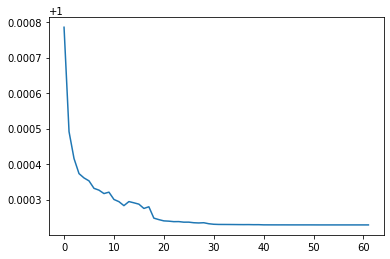

In [34]:
plt.plot(train_loss)
plt.show()

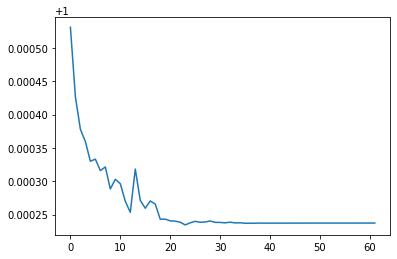

In [35]:
plt.plot(val_loss)
plt.show()

In [36]:
anc, pos, neg = train_dataset[0:10]

In [37]:
with torch.no_grad():
    a, b, c = net(anc, pos, neg)
    res1 = torch.column_stack([a, b, c])
    print(res1)

tensor([[13.1078, 13.3216,  4.3277],
        [11.0986, 11.1685, 12.7235],
        [13.7936, 13.7781, 11.1151],
        [10.4226, 10.4271, 13.6215],
        [15.0655, 14.9751, 10.4553],
        [11.4632, 11.5328, 13.1755],
        [ 0.5411,  0.8503, 11.6730],
        [10.6447, 10.4038,  0.6657],
        [ 5.0541,  5.3388, 10.2758],
        [16.3918, 16.1082,  5.2537]])


In [38]:
torch.save(net, "model/snn_kepl2d_triplet_01.pt")

In [39]:
test_dataset = Kepler2D(data_list, 5000)
test_dataloader = DataLoader(test_dataset, batch_size=500)

In [40]:
total_accuracy = 0
total_size = len(test_dataloader.dataset)
for batch, samples in enumerate(test_dataloader):
    x, x_p, x_n = samples
    x, x_p, x_n = x.to(device), x_p.to(device), x_n.to(device)
    with torch.no_grad():
        out1, out2, out3 = net(x, x_p, x_n)
        acc = torch.count_nonzero(torch.abs(out1 - out2) <= torch.abs(out1 - out3)).item()
        total_accuracy += acc
print(f"Average Accuracy: {total_accuracy/total_size*100}%")

Average Accuracy: 96.32%


In [41]:
def r2_score(target, output):
    target_mean = torch.mean(target)
    ss_tot = torch.sum((target - target_mean) ** 2)
    ss_res = torch.sum((target - output) ** 2)
    r2 = 1 - ss_res / ss_tot
    return r2

In [42]:
X, X_p, X_n = test_dataset[:]
X, X_p, X_n = X.to(device), X_p.to(device), X_n.to(device)

# x, y, vx, vy = X[:, 0], X[:,1], X[:,2], X[:,3]
# x, y, vx, vy = x.to(device), y.to(device), vx.to(device), vy.to(device)
x, y, vx, vy = X_n[:, 0], X_n[:,1], X_n[:,2], X_n[:,3]

# x = torch.cat([x, x_n])
# y = torch.cat([y, y_n])
# vx = torch.cat([vx, vx_n])
# vy = torch.cat([vy, vy_n])

net.eval()
with torch.no_grad():
#     Z1 = net(X)
#     Z2 = net(X_n)
#     Z = torch.vstack([Z1, Z2])
    _, _, Z = net(X, X_p, X_n)
Z

tensor([[ 5.2982],
        [ 8.8315],
        [15.6003],
        ...,
        [15.7814],
        [ 3.2856],
        [ 7.5287]])

In [43]:
Z.shape

torch.Size([5000, 1])

In [44]:
x.shape

torch.Size([5000])

In [45]:
X_linear = torch.column_stack([torch.ones((len(x), 1)).float().to(device), x, y, vx, vy])

In [46]:
weight_linear = torch.mm(torch.linalg.pinv(X_linear), Z)
weight_linear

tensor([[ 8.9021],
        [ 2.0473],
        [ 4.6602],
        [-0.0659],
        [-0.0863]])

In [47]:
r2_score(torch.mm(X_linear, weight_linear), Z)

tensor(0.8115)

In [48]:
X_quad = torch.column_stack([torch.ones((len(x), 1)).float().to(device), x, y, vx, vy, x**2, x*y, x*vx, x*vy, y**2, y*vx, y*vy, vx**2, vx*vy, vy**2])

In [49]:
X_quad.shape

torch.Size([5000, 15])

In [50]:
weight_quad = torch.mm(torch.linalg.pinv(X_quad), Z)
weight_quad

tensor([[ 8.8703e+00],
        [ 9.4572e-02],
        [ 2.9895e+00],
        [-1.8280e-03],
        [ 4.8196e-02],
        [-2.2820e-01],
        [-3.7419e-01],
        [ 1.0323e+00],
        [ 1.0781e+01],
        [ 1.9894e-01],
        [-9.5716e+00],
        [-3.6994e-01],
        [ 9.1735e-04],
        [-1.9422e-03],
        [ 3.2056e-02]])

In [51]:
r2_score(Z, torch.mm(X_quad, weight_quad))

tensor(0.9273)

In [85]:
class PolyNet(nn.Module):
    def __init__(self):
        super(PolyNet, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(14, 1),
            nn.ReLU()
        )

    def forward(self, x):
        return self.model(x)

In [86]:
net2 = PolyNet().to(device)

In [87]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(net2.parameters(), lr=0.1)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3)

In [88]:
train_dataset2 = Kepler2D(training_list, 50000)
valid_dataset2 = Kepler2D(val_list, 5000)

train_dataloader2 = DataLoader(train_dataset2, batch_size=500, shuffle=True)
valid_dataloader2 = DataLoader(valid_dataset2, batch_size=500)

dataloaders_dict2 = {
    "train": train_dataloader2,
    "val": valid_dataloader2
}

In [89]:
def train(net, net2, dataloaders_dict, criterion, optimizer, num_epochs):
    train_loss = []
    val_loss = []
    net.eval()
    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        print("----------------------")
        
        for phase in ['train', 'val']:
            if phase == 'train':
                net2.train()
            else:
                net2.eval()
                
            epoch_loss = 0.0
            epoch_r2 = 0.0
            
            data = dataloaders_dict[phase]
            for batch, samples in enumerate(tqdm(data)):
                X, X_p, X_n = samples
                X, X_p, X_n = X.to(device), X_p.to(device), X_n.to(device)
                
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase=="train"):
                    with torch.no_grad():
                        _, _, out = net(X, X_p, X_n)
                        x, y, vx, vy = X_n[:, 0], X_n[:,1], X_n[:,2], X_n[:,3]
                    X_quad = torch.column_stack([x, y, vx, vy, x**2, x*y, x*vx, x*vy, y**2, y*vx, y*vy, vx**2, vx*vy, vy**2])
                    Z = net2(X_quad)
                    loss = criterion(Z, out)
                    
                    if phase == "train":
                        loss.backward()
                        optimizer.step()
                    
                epoch_loss += loss.item() + X.shape[0]
                epoch_r2 += r2_score(Z, out) * batch
                    
            epoch_loss = epoch_loss / len(data.dataset)
            epoch_r2 = epoch_r2 / len(data.dataset) * 100
            
            if phase == 'train':
                train_loss.append(epoch_loss)
            else:
                val_loss.append(epoch_loss)
                scheduler.step(epoch_loss)
                lr = scheduler._last_lr[0]
                print(f" Validation Loss: {epoch_loss:>8f}")
                print(f" Validation R2  : {epoch_r2:>8f}")
                print(f" Learning Rate  : {lr:>8f}\n")
                if lr < 1e-6:
                    return train_loss, val_loss
            
    return train_loss, val_loss

In [90]:
train_loss2, val_loss2 = train(net, net2, dataloaders_dict2, criterion, optimizer, 500)

 11%|█         | 11/100 [00:00<00:00, 109.28it/s]

Epoch 1/500
----------------------


 15%|█▌        | 15/100 [00:00<00:00, 149.05it/s]

 Validation Loss: 1.012635
 Validation R2  : 0.671209
 Learning Rate  : 0.100000

Epoch 2/500
----------------------


 12%|█▏        | 12/100 [00:00<00:00, 116.23it/s]

 Validation Loss: 1.004894
 Validation R2  : 0.794847
 Learning Rate  : 0.100000

Epoch 3/500
----------------------


 14%|█▍        | 14/100 [00:00<00:00, 136.49it/s]

 Validation Loss: 1.003595
 Validation R2  : 0.820500
 Learning Rate  : 0.100000

Epoch 4/500
----------------------


 12%|█▏        | 12/100 [00:00<00:00, 117.81it/s]

 Validation Loss: 1.003449
 Validation R2  : 0.824823
 Learning Rate  : 0.100000

Epoch 5/500
----------------------


 14%|█▍        | 14/100 [00:00<00:00, 137.25it/s]

 Validation Loss: 1.003405
 Validation R2  : 0.825440
 Learning Rate  : 0.100000

Epoch 6/500
----------------------


 12%|█▏        | 12/100 [00:00<00:00, 115.67it/s]

 Validation Loss: 1.003436
 Validation R2  : 0.826841
 Learning Rate  : 0.100000

Epoch 7/500
----------------------


 11%|█         | 11/100 [00:00<00:00, 106.65it/s]

 Validation Loss: 1.003350
 Validation R2  : 0.827090
 Learning Rate  : 0.100000

Epoch 8/500
----------------------


 15%|█▌        | 15/100 [00:00<00:00, 143.23it/s]

 Validation Loss: 1.003444
 Validation R2  : 0.824864
 Learning Rate  : 0.010000

Epoch 9/500
----------------------


 12%|█▏        | 12/100 [00:00<00:00, 116.90it/s]

 Validation Loss: 1.003330
 Validation R2  : 0.827273
 Learning Rate  : 0.010000

Epoch 10/500
----------------------


 15%|█▌        | 15/100 [00:00<00:00, 146.47it/s]

 Validation Loss: 1.003329
 Validation R2  : 0.827476
 Learning Rate  : 0.010000

Epoch 11/500
----------------------


 15%|█▌        | 15/100 [00:00<00:00, 149.51it/s]

 Validation Loss: 1.003332
 Validation R2  : 0.827574
 Learning Rate  : 0.010000

Epoch 12/500
----------------------


 15%|█▌        | 15/100 [00:00<00:00, 146.71it/s]

 Validation Loss: 1.003330
 Validation R2  : 0.827220
 Learning Rate  : 0.010000

Epoch 13/500
----------------------


 14%|█▍        | 14/100 [00:00<00:00, 137.30it/s]

 Validation Loss: 1.003329
 Validation R2  : 0.827287
 Learning Rate  : 0.001000

Epoch 14/500
----------------------


 11%|█         | 11/100 [00:00<00:00, 100.15it/s]

 Validation Loss: 1.003329
 Validation R2  : 0.827369
 Learning Rate  : 0.001000

Epoch 15/500
----------------------


 15%|█▌        | 15/100 [00:00<00:00, 147.22it/s]

 Validation Loss: 1.003329
 Validation R2  : 0.827363
 Learning Rate  : 0.001000

Epoch 16/500
----------------------


 15%|█▌        | 15/100 [00:00<00:00, 146.24it/s]

 Validation Loss: 1.003329
 Validation R2  : 0.827393
 Learning Rate  : 0.001000

Epoch 17/500
----------------------


 15%|█▌        | 15/100 [00:00<00:00, 149.67it/s]

 Validation Loss: 1.003330
 Validation R2  : 0.827372
 Learning Rate  : 0.000100

Epoch 18/500
----------------------


 16%|█▌        | 16/100 [00:00<00:00, 151.12it/s]

 Validation Loss: 1.003330
 Validation R2  : 0.827374
 Learning Rate  : 0.000100

Epoch 19/500
----------------------


 15%|█▌        | 15/100 [00:00<00:00, 143.51it/s]

 Validation Loss: 1.003330
 Validation R2  : 0.827376
 Learning Rate  : 0.000100

Epoch 20/500
----------------------


 15%|█▌        | 15/100 [00:00<00:00, 147.70it/s]

 Validation Loss: 1.003330
 Validation R2  : 0.827377
 Learning Rate  : 0.000100

Epoch 21/500
----------------------


 13%|█▎        | 13/100 [00:00<00:00, 126.57it/s]

 Validation Loss: 1.003330
 Validation R2  : 0.827380
 Learning Rate  : 0.000010

Epoch 22/500
----------------------


 11%|█         | 11/100 [00:00<00:00, 106.55it/s]

 Validation Loss: 1.003330
 Validation R2  : 0.827380
 Learning Rate  : 0.000010

Epoch 23/500
----------------------


 14%|█▍        | 14/100 [00:00<00:00, 137.73it/s]

 Validation Loss: 1.003330
 Validation R2  : 0.827381
 Learning Rate  : 0.000010

Epoch 24/500
----------------------


 15%|█▌        | 15/100 [00:00<00:00, 143.72it/s]

 Validation Loss: 1.003330
 Validation R2  : 0.827381
 Learning Rate  : 0.000010

Epoch 25/500
----------------------


 15%|█▌        | 15/100 [00:00<00:00, 147.00it/s]

 Validation Loss: 1.003330
 Validation R2  : 0.827381
 Learning Rate  : 0.000001

Epoch 26/500
----------------------


 15%|█▌        | 15/100 [00:00<00:00, 149.20it/s]

 Validation Loss: 1.003330
 Validation R2  : 0.827381
 Learning Rate  : 0.000001

Epoch 27/500
----------------------


 16%|█▌        | 16/100 [00:00<00:00, 151.20it/s]

 Validation Loss: 1.003330
 Validation R2  : 0.827381
 Learning Rate  : 0.000001

Epoch 28/500
----------------------


 13%|█▎        | 13/100 [00:00<00:00, 124.75it/s]

 Validation Loss: 1.003330
 Validation R2  : 0.827381
 Learning Rate  : 0.000001

Epoch 29/500
----------------------


100%|██████████| 10/10 [00:00<00:00, 79.34it/s]

 Validation Loss: 1.003330
 Validation R2  : 0.827381
 Learning Rate  : 0.000000



In [91]:
for param in net2.parameters():
  print(param.data)

tensor([[ 1.2686e-01,  3.0127e+00, -6.4998e-03,  4.2949e-02, -2.7042e-01,
         -4.5391e-01,  1.0109e+00,  1.0624e+01,  1.4490e-01, -9.4050e+00,
         -2.5515e-01, -3.5943e-02, -2.0206e-02,  2.0230e-02]])
tensor([8.9815])


In [61]:
class PolyNet2(nn.Module):
    def __init__(self):
        super(PolyNet2, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(15, 1),
            nn.ReLU()
        )

    def forward(self, x):
        return self.model(x)

In [62]:
net3 = PolyNet2().to(device)

In [63]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(net2.parameters(), lr=1)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3)